In [1]:
import numpy as np
import math
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

In [2]:
IBMQ.delete_account()
IBMQ.save_account('token')
IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def input_state(circ, q, n):
    """n-qubit input state for QFT that produces output 1."""
    for j in range(n):
        circ.h(q[j])
        circ.u1(math.pi/float(2**(j)), q[j]).inverse()

def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])

In [17]:
n = 3  # No. of qubits
q = QuantumRegister(n)
c = ClassicalRegister(n)
qft_n = QuantumCircuit(q, c)

#input_state(qft_n, q, n)
qft(qft_n, q, n)
for i in range(n):
    qft_n.measure(q[i], c[i])
print(qft_n.qasm())

Traceback (most recent call last):
  File "<ipython-input-17-c6c94ada1429>", line 7, in <module>
    qft(qft_n, q, n)
TypeError: qft() takes 2 positional arguments but 3 were given

Use %tb to get the full traceback.


In [4]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qft3 = QuantumCircuit(q, c)

input_state(qft3, q, 3)
qft(qft3, q, 3)
for i in range(3):
    qft3.measure(q[i], c[i])
print(qft3.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
h q0[0];
u1(pi) q0[0];
h q0[1];
u1(pi/2) q0[1];
h q0[2];
u1(pi/4) q0[2];
h q0[0];
cu1(pi/2) q0[1],q0[0];
h q0[1];
cu1(pi/4) q0[2],q0[0];
cu1(pi/2) q0[2],q0[1];
h q0[2];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];
measure q0[2] -> c0[2];



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")

simulate = execute(qft3, backend=backend, shots=1024).result()
simulate.get_counts()

{'111': 1024}

In [6]:
# Use the IBM Quantum Experience
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cu1(pi/2**(n-qubit), qubit, n)

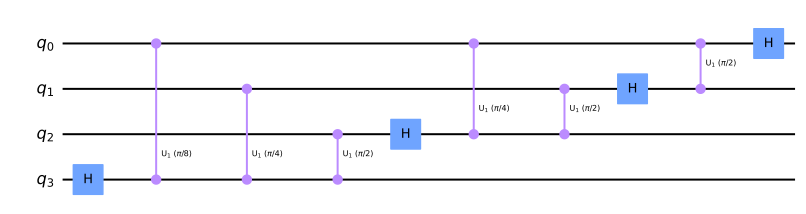

In [15]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

In [7]:
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfb\x00\x00\x01\x08\x08\x06\x00\x00\x00X\x8d]e\x…

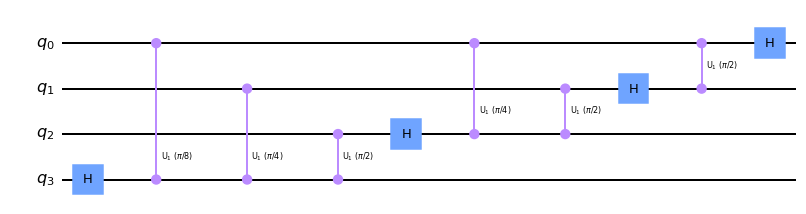

In [8]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

In [9]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x19\x00\x00\x01\x08\x08\x06\x00\x00\x00\x1a\xcd,…

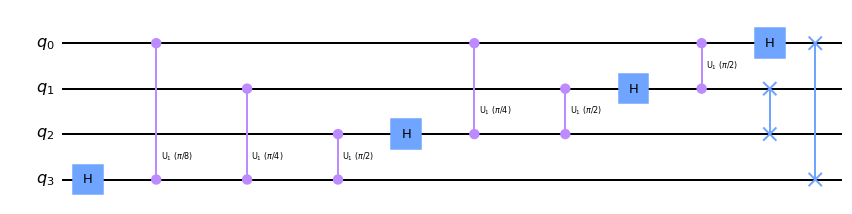

In [10]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

In [11]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04U\x00\x00\x01\x08\x08\x06\x00\x00\x00\x9eK\xcbE\x…

In [12]:
bin(5)

'0b101'

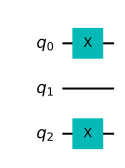

In [13]:
qc = QuantumCircuit(3)

qc.x(0)
qc.x(2)
%config InlineBackend.figure_format = 'svg'
qc.draw('mpl')

In [18]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

Traceback (most recent call last):
  File "<ipython-input-18-4f58cecb6e8e>", line 3, in <module>
    plot_bloch_multivector(statevector)
NameError: name 'plot_bloch_multivector' is not defined

Use %tb to get the full traceback.


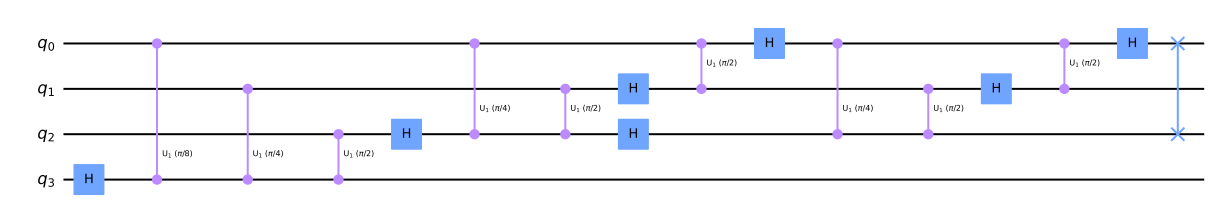

In [19]:
qft(qc,3)
qc.draw('mpl')

In [20]:
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

Traceback (most recent call last):
  File "<ipython-input-20-8783b67ed0da>", line 2, in <module>
    plot_bloch_multivector(statevector)
NameError: name 'plot_bloch_multivector' is not defined

Use %tb to get the full traceback.


In [41]:
def inverse_qft(circuit, n):
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

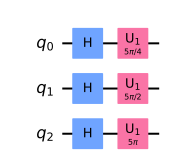

In [42]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl')

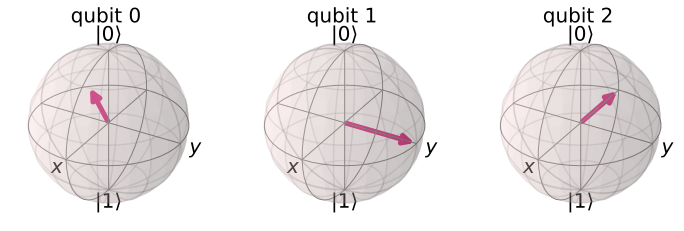

In [43]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

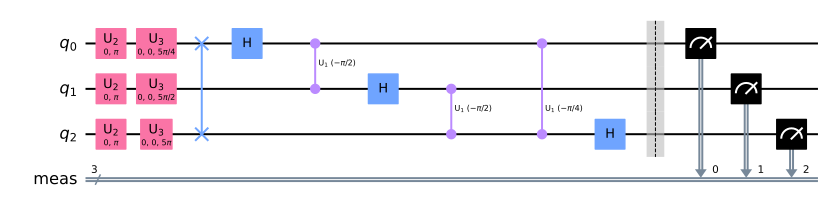

In [44]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [46]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_valencia


In [47]:
shots = 2048
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


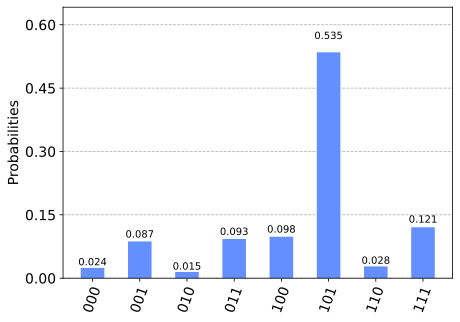

In [49]:
counts = job.result().get_counts()
plot_histogram(counts)

In [50]:
# We wish to compute the fast fourier transform of bit string 01000000
# Wavefunction is an object that stores a quantum state as a list of amplitudes. 
# In this part we will check wether the wavefunction of QFT is the same to that of the iFFT.
# if the results are same, it indicates QFT is correct

# QFT
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), q[j], q[k])  # cu1 is the controlled phase gate Rm
        circ.h(q[j])

n = 3  # No. of qubits
q = QuantumRegister(n)
c = ClassicalRegister(n)
qft_n = QuantumCircuit(q, c)

qft_n.x(q[2])  # Add X gate to the 2nd qubit, to make it from 0 to 1. Now the input quantum state is |001>
qft(qft_n, q, n)

backend = Aer.get_backend('statevector_simulator')
result = execute(qft_n, backend=backend).result()
result.data(qft_n)

{'counts': {'0x0': 1},
 'statevector': array([ 3.53553391e-01-4.32978028e-17j,  2.50000000e-01+2.50000000e-01j,
         6.49467042e-17+3.53553391e-01j, -2.50000000e-01+2.50000000e-01j,
        -3.53553391e-01+4.32978028e-17j, -2.50000000e-01-2.50000000e-01j,
        -6.49467042e-17-3.53553391e-01j,  2.50000000e-01-2.50000000e-01j])}

In [51]:
# Applying QFT to a vector corresponds to applying inverse FFT to it.
# iFFT
from numpy.fft import ifft
ifft([0,1,0,0,0,0,0,0], norm="ortho")

array([ 0.35355339+0.j        ,  0.25      +0.25j      ,
        0.        +0.35355339j, -0.25      +0.25j      ,
       -0.35355339+0.j        , -0.25      -0.25j      ,
        0.        -0.35355339j,  0.25      -0.25j      ])